In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings 

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)

from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer

from lightning.pytorch.tuner import Tuner

import tensorflow as tf
# import tensorboard as tb

from pathlib import Path
import sys
#If you get an error either delete or add a parent
project_root = Path('.').resolve().parent
sys.path.append(str(project_root))
print("Project root:", project_root)
print("Python path:", sys.path)

from deepvar import lstm
from tools import helpers as hp
from var import stationary as st
from deepvar import tft

warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but StandardScaler was fitted with feature names')
warnings.filterwarnings('ignore', message='An unsupported index was provided and will be ignored when e.g. forecasting.')

Project root: /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results
Python path: ['/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/bram/Library/Python/3.10/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages', '/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/tmpyby2xr_j', '/Users/bram/Desktop/Honors Draft for Reviewers', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis', '/Users/bram/Desktop/Honors Draft for Reviewers', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results', '/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Househo

In [17]:
def prepare_df(df):
    df['log_GDP'] = df['l_GDP_dif']
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df



Basic VAR detrend results

In [18]:
df = pd.read_csv('./../Data/WithoutPolicyRate.csv')

def prepare_df(df):
    df['log_GDP'] = np.log(df['GDP']) 
    final_df = df.copy()
    final_df['TIME_PERIOD'] = pd.to_datetime(final_df['TIME_PERIOD'])
    final_df = final_df.set_index(["Country", "TIME_PERIOD"])
    final_df = final_df.drop(columns = {"Code", "GDP", 'CPI'})
    return final_df

variables_to_keep = ['log_GDP','hd_dif','pd_dif','quarter','country_id']
df = prepare_df(df)
variables = df.columns
final_detrend = st.detrend_data(df, variables, 1) 
df = final_detrend[final_detrend.index.get_level_values("TIME_PERIOD")< "2020-03-31"]

df

Index(['Colombia', 'Netherlands, The', 'United Kingdom', 'India', 'Israel',
       'Sweden', 'Thailand', 'Australia', 'New Zealand', 'Ireland', 'Germany',
       'Brazil', 'Mexico', 'Greece', 'Norway', 'Austria', 'Italy', 'Argentina',
       'Singapore', 'France', 'Portugal', 'Hungary', 'Spain', 'Canada',
       'Switzerland', 'United States', 'Denmark', 'Indonesia',
       'China, P.R.: Hong Kong', 'Luxembourg', 'Japan', 'Finland',
       'South Africa', 'Chile', 'Czech Rep.', 'Poland, Rep. of',
       'Türkiye, Rep of', 'Korea, Rep. of', 'Belgium'],
      dtype='object', name='Country')


private_debt  household_debt  exchange_rate   log_GDP
Country  TIME_PERIOD                                                       
Colombia 2005-06-30         -0.682           0.494       1.546667  0.020220
         2005-09-30         -0.743           0.320       1.363333 -0.000439
         2005-12-31         -0.278           0.690       1.666667  0.018095
         2006-03-31         -0.160          -0.076       0.436667  0.021254
         2006-06-30          0.660           0.713      -7.830000  0.016457
...                            ...             ...            ...       ...
Belgium  2018-12-31          0.900           0.300       0.285000  0.009724
         2019-03-31         -0.200           0.400      -0.235000  0.002609
         2019-06-30         -0.900           0.300      -0.815000  0.005386
         2019-09-30          2.300           0.000      -0.568333  0.007315
         2019-12-31         -1.400           0.700      -0.356667  0.005931

[4065 rows x 4 columns]

In [19]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [20]:
df = tft.prepare_panel_data(df)
df = lstm.create_lstm_data(df, 1)
df = df[["time_idx", 'Country_index', 'log_GDP','household_debt','private_debt', 'log_GDP_lag1', 'household_debt_lag1', 'private_debt_lag1']]

df

,,time_idx,Country_index,log_GDP,household_debt,private_debt,log_GDP_lag1,household_debt_lag1,private_debt_lag1
TIME_PERIOD,Country,,,,,,,,
1964-06-30,United States,0,United States,0.010832,0.6,0.4,NaN,NaN,NaN
1964-09-30,United States,1,United States,0.015505,0.2,-0.1,0.010832,0.6,0.4
1964-12-31,United States,2,United States,0.003087,0.5,0.5,0.015505,0.2,-0.1
1965-03-31,United States,3,United States,0.023911,-0.3,0.2,0.003087,0.5,0.5
1965-06-30,United States,4,United States,0.012556,0.5,0.5,0.023911,-0.3,0.2
...,...,...,...,...,...,...,...,...,...
2018-12-31,South Africa,42,South Africa,0.002771,0.2,-1.1,0.012223,-0.2,0.3
2019-03-31,South Africa,43,South Africa,-0.008773,0.2,1.8,0.002771,0.2,-1.1
2019-06-30,South Africa,44,South Africa,0.004512,0.0,-1.1,-0.008773,0.2,1.8


In [21]:
df

,,time_idx,Country_index,log_GDP,household_debt,private_debt,log_GDP_lag1,household_debt_lag1,private_debt_lag1
TIME_PERIOD,Country,,,,,,,,
1964-06-30,United States,0,United States,0.010832,0.6,0.4,NaN,NaN,NaN
1964-09-30,United States,1,United States,0.015505,0.2,-0.1,0.010832,0.6,0.4
1964-12-31,United States,2,United States,0.003087,0.5,0.5,0.015505,0.2,-0.1
1965-03-31,United States,3,United States,0.023911,-0.3,0.2,0.003087,0.5,0.5
1965-06-30,United States,4,United States,0.012556,0.5,0.5,0.023911,-0.3,0.2
...,...,...,...,...,...,...,...,...,...
2018-12-31,South Africa,42,South Africa,0.002771,0.2,-1.1,0.012223,-0.2,0.3
2019-03-31,South Africa,43,South Africa,-0.008773,0.2,1.8,0.002771,0.2,-1.1
2019-06-30,South Africa,44,South Africa,0.004512,0.0,-1.1,-0.008773,0.2,1.8


In [22]:
max_prediction_length = 10
max_encoder_length = 3 #lookback window
df = df.dropna()
train, test = hp.time_panel_split_predict(df, train_fraction=.7)

training_cutoff = train["time_idx"].max() - max_prediction_length

test['log_GDP']


TIME_PERIOD  Country      
2003-06-30   United States    0.008817
2003-09-30   United States    0.016495
2003-12-31   United States    0.011540
2004-03-31   United States    0.005651
2004-06-30   United States    0.007720
                                ...   
2018-12-31   South Africa     0.002771
2019-03-31   South Africa    -0.008773
2019-06-30   South Africa     0.004512
2019-09-30   South Africa     0.001050
2019-12-31   South Africa    -0.000362
Name: log_GDP, Length: 1228, dtype: float64

In [23]:

arg = test[test.index.get_level_values('Country') == "Argentina"]

arg['log_GDP']




TIME_PERIOD  Country  
2015-06-30   Argentina    0.025892
2015-09-30   Argentina   -0.002477
2015-12-31   Argentina   -0.011651
2016-03-31   Argentina   -0.007528
2016-06-30   Argentina   -0.017594
2016-09-30   Argentina    0.003113
2016-12-31   Argentina    0.006712
2017-03-31   Argentina    0.009196
2017-06-30   Argentina    0.009446
2017-09-30   Argentina    0.013660
2017-12-31   Argentina    0.009744
2018-03-31   Argentina   -0.006351
2018-06-30   Argentina   -0.042862
2018-09-30   Argentina   -0.001690
2018-12-31   Argentina   -0.015403
2019-03-31   Argentina    0.002017
2019-06-30   Argentina    0.005161
2019-09-30   Argentina    0.001339
2019-12-31   Argentina   -0.013682
Name: log_GDP, dtype: float64

Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 304.9k
Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
Finding best initial lr: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]
Learning rate set to 0.00015848931924611134
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/Future Work/.lr_find_2f5e30d3-37cc-42a4-9a42-adfaefd2e4a9.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/Future Work/.lr_find_2f5e30d3-37cc-42a4-9a42-adfaefd2e4a9.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Py

Suggested learning rate: 0.00015848931924611134
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30: 100%|██████████| 30/30 [00:02<00:00, 14.56it/s, v_num=0, train_loss_step=0.00727, val_loss=0.00748, train_loss_epoch=0.00749]


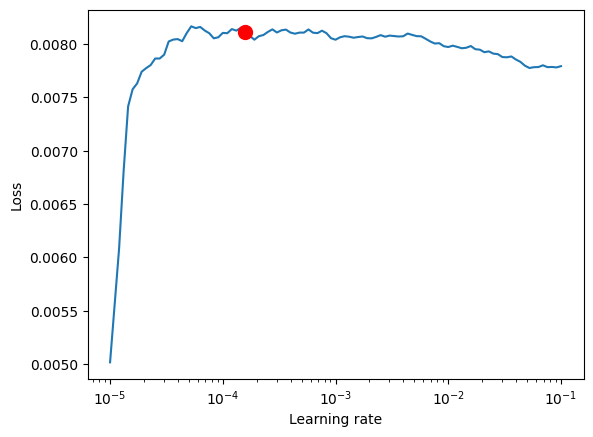

In [24]:
inputs = ['time_idx', 'log_GDP_lag1', 'household_debt_lag1', 'private_debt_lag1']
target_col = 'log_GDP'
max_prediction_length = 10
max_encoder_length = 12
batch_size = 64

tft_model, tft_training = tft.train_temporal_fusion_transformer(
    train_data=train,
    max_prediction_length=max_prediction_length,
    max_encoder_length=max_encoder_length,
    max_epochs=50,
    target_col= target_col,
    group_ids= ['Country_index'],
    known_reals= inputs,
    batch_size=batch_size,
    patience=30,
    learning_rate=None,
    loss = "MAE"
)

In [25]:
train

,,time_idx,Country_index,log_GDP,household_debt,private_debt,log_GDP_lag1,household_debt_lag1,private_debt_lag1
TIME_PERIOD,Country,,,,,,,,
1964-09-30,United States,1,United States,0.015505,0.2,-0.1,0.010832,0.6,0.4
1964-12-31,United States,2,United States,0.003087,0.5,0.5,0.015505,0.2,-0.1
1965-03-31,United States,3,United States,0.023911,-0.3,0.2,0.003087,0.5,0.5
1965-06-30,United States,4,United States,0.012556,0.5,0.5,0.023911,-0.3,0.2
1965-09-30,United States,5,United States,0.021988,0.0,-0.1,0.012556,0.5,0.5
...,...,...,...,...,...,...,...,...,...
2015-06-30,South Africa,28,South Africa,-0.008478,-0.3,-0.1,0.007198,-0.3,1.3
2015-09-30,South Africa,29,South Africa,0.004494,-0.2,0.5,-0.008478,-0.3,-0.1
2015-12-31,South Africa,30,South Africa,0.004325,0.1,1.5,0.004494,-0.2,0.5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


   time_idx       date
0       158 2003-12-31
1       159 2004-03-31
2       160 2004-06-30
3       161 2004-09-30
4       162 2004-12-31
5       163 2005-03-31
6       164 2005-06-30
7       165 2005-09-30
8       166 2005-12-31
9       167 2006-03-31
0   2003-12-31
1   2004-03-31
2   2004-06-30
3   2004-09-30
4   2004-12-31
5   2005-03-31
6   2005-06-30
7   2005-09-30
8   2005-12-31
9   2006-03-31
Name: date, dtype: datetime64[ns]
Observe tensor([ 0.0107, -0.0007,  0.0242,  0.0122, -0.0018,  0.0006,  0.0152,  0.0093,
         0.0010, -0.0166])
Predicted [[0.01557088]
 [0.01381568]
 [0.01062612]
 [0.0137252 ]
 [0.01592356]
 [0.00887117]
 [0.01128232]
 [0.01441008]
 [0.01431874]
 [0.01125558]]
0   2003-12-31
1   2004-03-31
2   2004-06-30
3   2004-09-30
4   2004-12-31
5   2005-03-31
6   2005-06-30
7   2005-09-30
8   2005-12-31
9   2006-03-31
Name: date, dtype: datetime64[ns]
Observe tensor([0.0080, 0.0072, 0.0041, 0.0031, 0.0067, 0.0109, 0.0130, 0.0050, 0.0073,
        0.0074])
Predicte

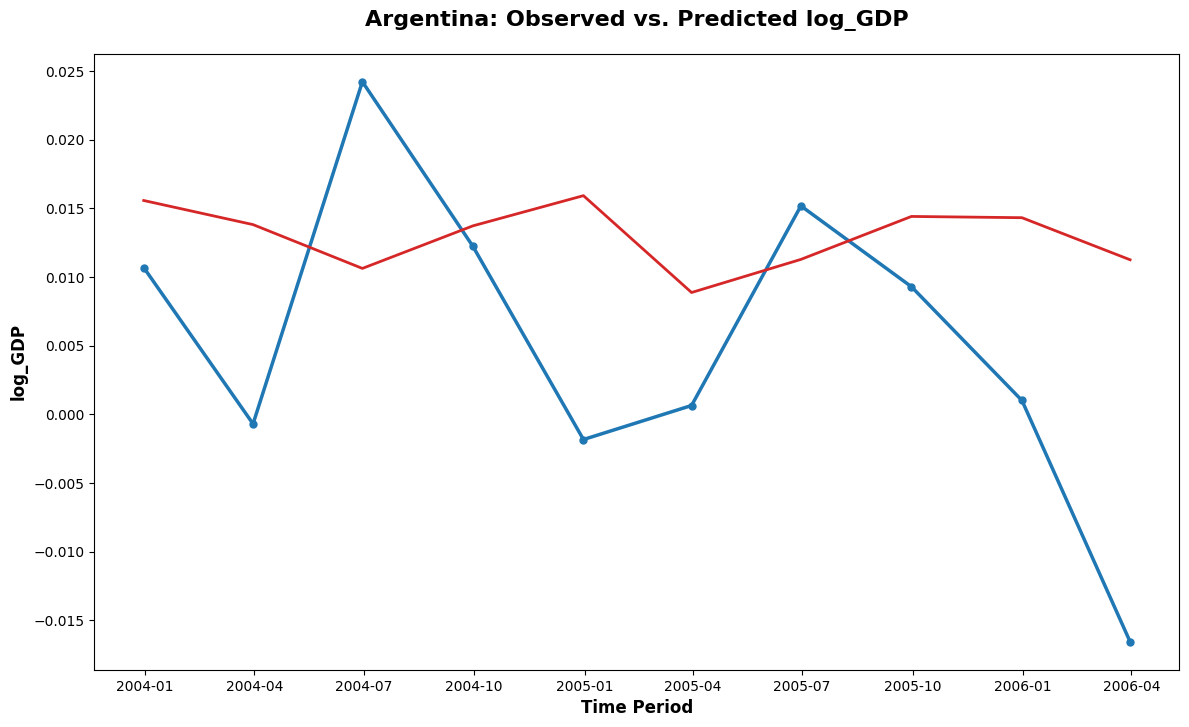

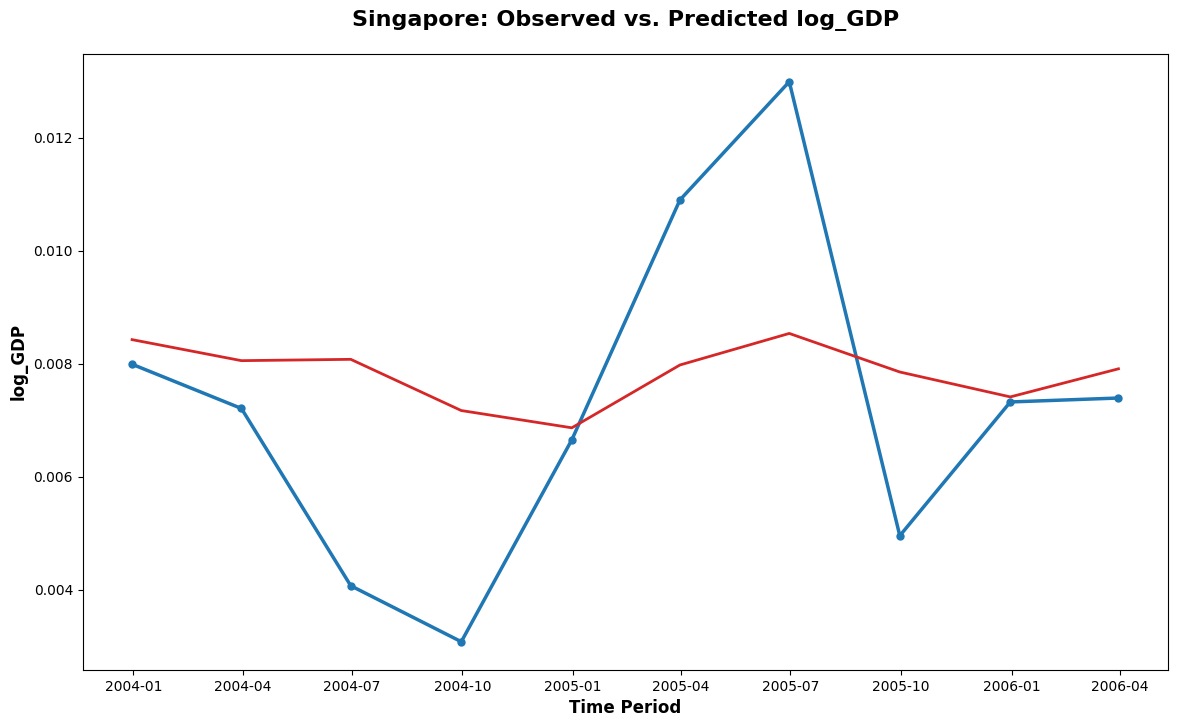

In [26]:
last_time_for_prediction = df['time_idx'].max()
test_dataloader = tft.get_test_data_unbalanced(df, max_prediction_length, max_encoder_length, tft_training, batch_size)
actuals, predictions, raw_predictions, x = tft.get_predictions(test_dataloader, tft_model, DEVICE, loss = "MAE")

prediction_index = tft.get_prediction_index(x, df)

tft.plot_country_predictions('Argentina', raw_predictions, actuals, prediction_index, test, loss = "MAE", target_var = "log_GDP")

tft.plot_country_predictions('Singapore', raw_predictions, actuals, prediction_index, test, loss = "MAE", target_var = "log_GDP")


In [27]:
print(tft.get_country_tft_actual(test, actuals, "Argentina"))


print(tft.get_country_tft_predicitons(test, raw_predictions, "Argentina"))

print(x)


tensor([ 0.0107, -0.0007,  0.0242,  0.0122, -0.0018,  0.0006,  0.0152,  0.0093,
         0.0010, -0.0166])
[[0.01557088]
 [0.01381568]
 [0.01062612]
 [0.0137252 ]
 [0.01592356]
 [0.00887117]
 [0.01128232]
 [0.01441008]
 [0.01431874]
 [0.01125558]]
{'encoder_cat': tensor([[[ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0],
         [ 0]],

        [[ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1]],

        [[ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2],
         [ 2]],

        [[ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3],
         [ 3]],

        

In [28]:
test



,,time_idx,Country_index,log_GDP,household_debt,private_debt,log_GDP_lag1,household_debt_lag1,private_debt_lag1
TIME_PERIOD,Country,,,,,,,,
2003-06-30,United States,156,United States,0.008817,2.7,-0.4,0.005253,0.9,-0.5
2003-09-30,United States,157,United States,0.016495,1.2,-0.4,0.008817,2.7,-0.4
2003-12-31,United States,158,United States,0.011540,1.0,-0.8,0.016495,1.2,-0.4
2004-03-31,United States,159,United States,0.005651,0.2,0.1,0.011540,1.0,-0.8
2004-06-30,United States,160,United States,0.007720,1.2,-0.3,0.005651,0.2,0.1
...,...,...,...,...,...,...,...,...,...
2018-12-31,South Africa,42,South Africa,0.002771,0.2,-1.1,0.012223,-0.2,0.3
2019-03-31,South Africa,43,South Africa,-0.008773,0.2,1.8,0.002771,0.2,-1.1
2019-06-30,South Africa,44,South Africa,0.004512,0.0,-1.1,-0.008773,0.2,1.8


In [30]:
train

,,time_idx,Country_index,log_GDP,household_debt,private_debt,log_GDP_lag1,household_debt_lag1,private_debt_lag1
TIME_PERIOD,Country,,,,,,,,
1964-09-30,United States,1,United States,0.015505,0.2,-0.1,0.010832,0.6,0.4
1964-12-31,United States,2,United States,0.003087,0.5,0.5,0.015505,0.2,-0.1
1965-03-31,United States,3,United States,0.023911,-0.3,0.2,0.003087,0.5,0.5
1965-06-30,United States,4,United States,0.012556,0.5,0.5,0.023911,-0.3,0.2
1965-09-30,United States,5,United States,0.021988,0.0,-0.1,0.012556,0.5,0.5
...,...,...,...,...,...,...,...,...,...
2015-06-30,South Africa,28,South Africa,-0.008478,-0.3,-0.1,0.007198,-0.3,1.3
2015-09-30,South Africa,29,South Africa,0.004494,-0.2,0.5,-0.008478,-0.3,-0.1
2015-12-31,South Africa,30,South Africa,0.004325,0.1,1.5,0.004494,-0.2,0.5


Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 305.2k
Finding optimal learning rate...


Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 21.20it/s]
Learning rate set to 0.0030199517204020166
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/Future Work/.lr_find_afc67647-269d-42b7-a3d8-9a03204482d5.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/Future Work/.lr_find_afc67647-269d-42b7-a3d8-9a03204482d5.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                               | Type                            | Params | Mode 
----------------------------------------------------------------------

Suggested learning rate: 0.0030199517204020166
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30: 100%|██████████| 30/30 [00:01<00:00, 16.08it/s, v_num=2, train_loss_step=0.00536, val_loss=0.00511, train_loss_epoch=0.00505]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


IndexError: index 1 is out of bounds for dimension 0 with size 1

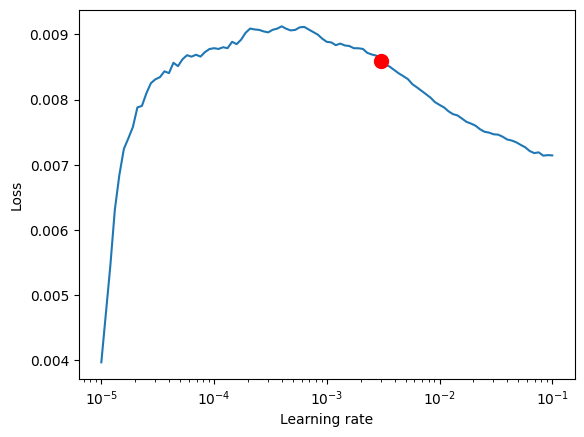

In [33]:
inputs = ['time_idx', 'log_GDP_lag1', 'household_debt_lag1', 'private_debt_lag1']
target_col = 'log_GDP'
max_prediction_length = 10
max_encoder_length = 3
batch_size = 32

lossfunc = "quantile"

tft_model, tft_training = tft.train_temporal_fusion_transformer(
    train_data=train,
    max_prediction_length=max_prediction_length,
    max_encoder_length=max_encoder_length,
    max_epochs=50,
    target_col= target_col,
    group_ids= ['Country_index'],
    known_reals= inputs,
    batch_size=batch_size,
    patience=30,
    learning_rate=None,
    loss = lossfunc
)

last_time_for_prediction = df['time_idx'].max()
test_dataloader = tft.get_test_data(df, last_time_for_prediction, max_prediction_length, max_encoder_length, tft_training, batch_size)

actuals, predictions, raw_predictions, x = tft.get_predictions(test_dataloader, tft_model, DEVICE, loss = lossfunc)

prediction_index = tft.get_prediction_index(x, df)

tft.plot_country_predictions('United States', raw_predictions, actuals, prediction_index, test, loss = lossfunc, target_var = "l_GDP_dif")

tft.plot_country_predictions('Singapore', raw_predictions, actuals, prediction_index, test, loss = lossfunc, target_var = "l_GDP_dif")


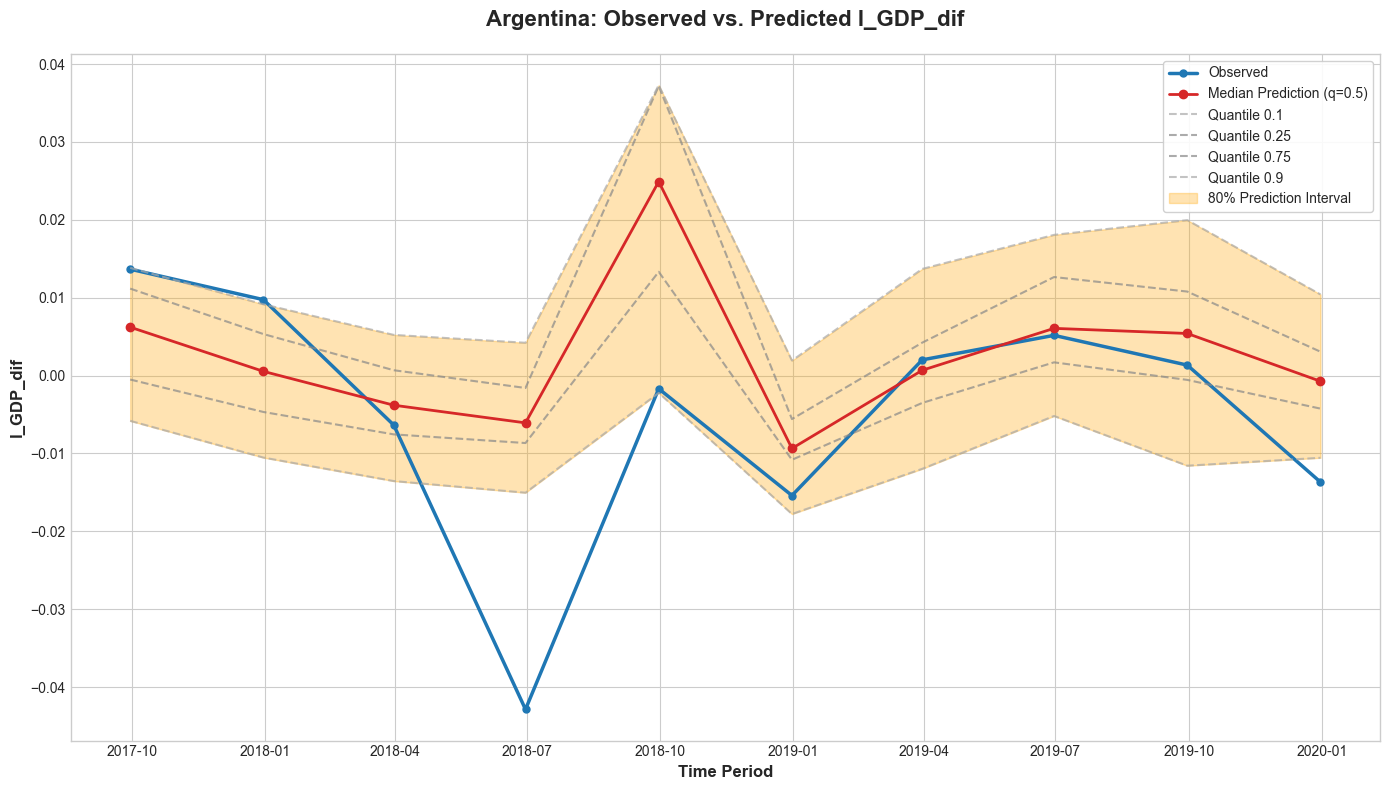

tensor([ 0.0137,  0.0097, -0.0064, -0.0429, -0.0017, -0.0154,  0.0020,  0.0052,
         0.0013, -0.0137])

In [ ]:
tft.plot_country_predictions('Argentina', raw_predictions, actuals, prediction_index, test, loss = lossfunc, target_var = "l_GDP_dif")
actuals[0]

Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 304.9k
Finding optimal learning rate...


Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 22.90it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6532df97-fe5a-422a-9939-eaeef053efd0.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_6532df97-fe5a-422a-9939-eaeef053efd0.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                               | Type                            | Params | Mode 
---------------------------------------------------------------------------------------------

Suggested learning rate: 2.7542287033381663e-05
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 22: 100%|██████████| 26/26 [00:01<00:00, 18.66it/s, v_num=183, train_loss_step=0.0158, val_loss=0.00745, train_loss_epoch=0.00976] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

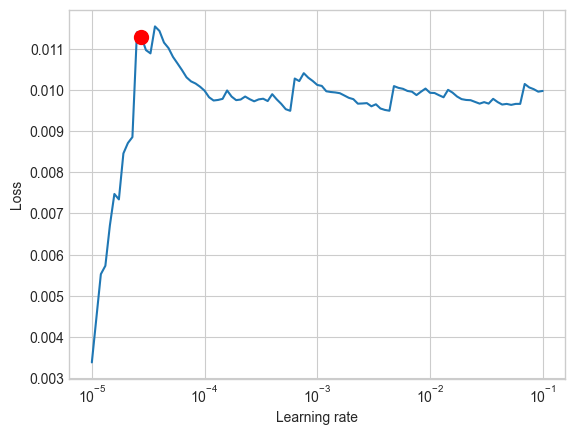

In [ ]:
country_name = 'United States'
num_steps = 10  
start_time_idx = df['time_idx'].max()-num_steps+1   
max_prediction_length_onestep = 1
max_encoder_length_onestep = 10
country_index = tft.get_country_index(df, country_name)
target_col = 'l_GDP_dif'
inputs = ['time_idx', 'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1']
batch_size = 32


tft_onestep, tft_onestep_training = tft.train_temporal_fusion_transformer(
    train_data=train,
    max_prediction_length=max_prediction_length_onestep,
    max_encoder_length=max_encoder_length_onestep,
    max_epochs=50,
    target_col= target_col,
    group_ids= ['Country_index'],
    known_reals= inputs,
    batch_size=batch_size,
    patience=30,
    learning_rate=None,
    loss = "RMSE"
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/P

SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 37
SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 38


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:42

SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 39
SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:42

SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 41
SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 42


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:42

SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 43
SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 44


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:42

SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 45
SHAPE_Allpredictions torch.Size([39, 1, 1])
Completed prediction for time index 46
SHAPE_ALL_PREDICTIONS torch.Size([39, 10, 1])


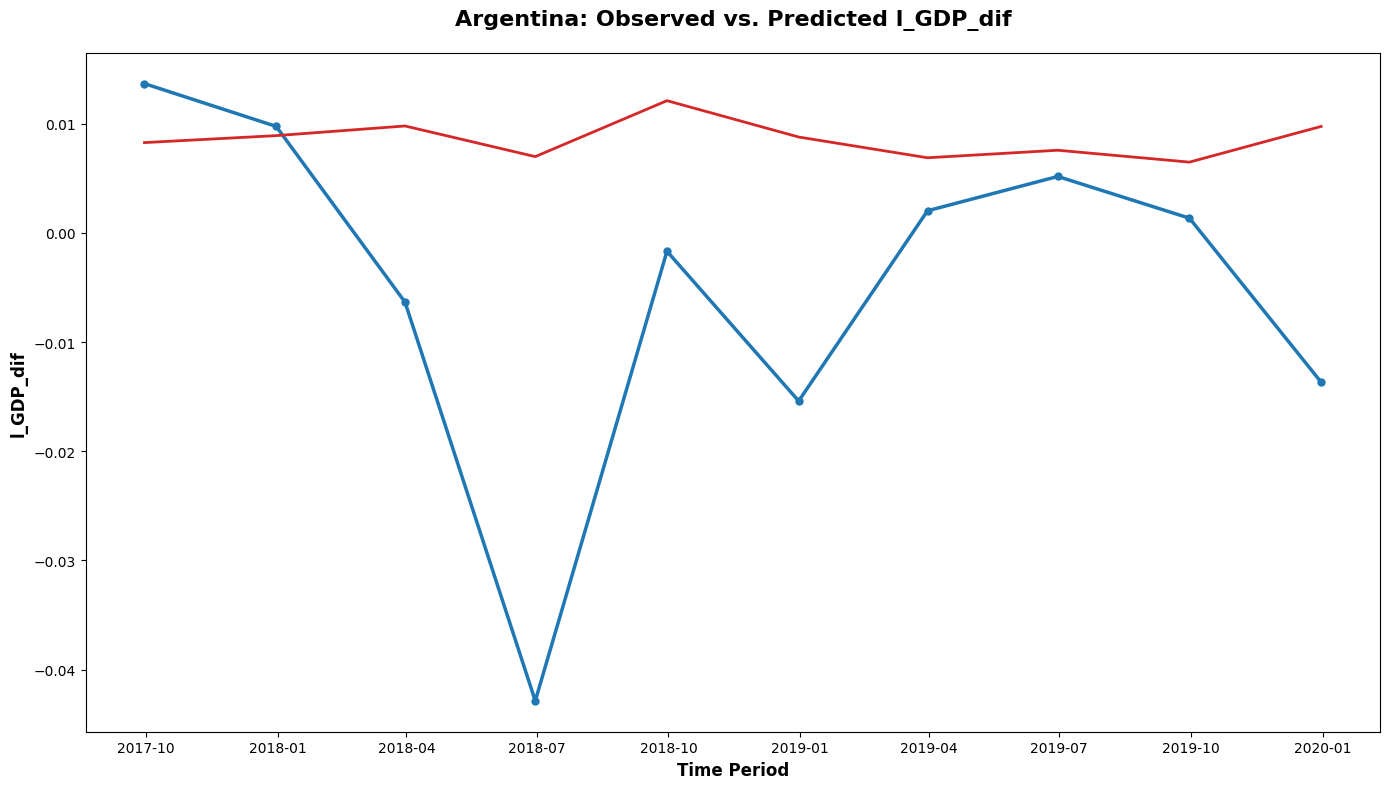

In [ ]:
one_step_predictions, one_step_actuals = tft.predict_over_time_steps(
    df=df,
    tft_onestep=tft_onestep,
    training=tft_onestep_training,
    start_time_idx=start_time_idx,
    max_encoder_length_onestep=max_encoder_length_onestep,
    num_steps=num_steps,
    batch_size=batch_size,
    device=DEVICE,
)
prediction_index_onestep = df['time_idx'].max()-num_steps
tft.plot_onestep_country_predictions(one_step_predictions, one_step_actuals, prediction_index_onestep, "Argentina", 'l_GDP_dif', "RMSE", df)
# plot_onestep_country_predictions(one_step_predictions, one_step_actuals, prediction_index_onestep, "Singapore", "l_GDP_dif", "RMSE", df)


In [ ]:
country_name = 'United States'
num_steps = 10  
start_time_idx = df['time_idx'].max()-num_steps+1   
max_prediction_length_onestep = 1
max_encoder_length_onestep = 10
country_index = tft.get_country_index(df, country_name)
target_col = 'l_GDP_dif'
inputs = ['time_idx', 'l_GDP_dif_lag1', 'hd_dif_lag1', 'pd_dif_lag1']
batch_size = 32

Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3

Number of parameters in network: 304.9k
Finding optimal learning rate...


`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [00:05<00:00, 18.97it/s]
Learning rate set to 2.7542287033381663e-05
Restoring states from the checkpoint path at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_5ac1ca0a-5951-49a5-9a8a-3dca05c9af89.ckpt
Restored all states from the checkpoint at /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/.lr_find_5ac1ca0a-5951-49a5-9a8a-3dca05c9af89.ckpt
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

   | Name                               | Type                            | Params | Mode 
---------------------------------------------

Suggested learning rate: 2.7542287033381663e-05
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30: 100%|██████████| 26/26 [00:01<00:00, 19.85it/s, v_num=188, train_loss_step=0.00568, val_loss=0.00737, train_loss_epoch=0.00949]

Seed set to 42



Number of parameters in network: 304.9k


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9

Suggested learning rate: 3.981071705534973e-05
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 26/26 [00:01<00:00, 16.11it/s, v_num=189, train_loss_step=0.598, val_loss=0.676, train_loss_epoch=0.607]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 26/26 [00:01<00:00, 15.69it/s, v_num=189, train_loss_step=0.598, val_loss=0.676, train_loss_epoch=0.607]


Seed set to 42
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 304.9k
Finding optimal learning rate...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/checkpoints exists and is not empty.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9

Suggested learning rate: 3.0199517204020165e-05
                                                                           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 35: 100%|██████████| 26/26 [00:01<00:00, 18.45it/s, v_num=190, train_loss_step=2.720, val_loss=1.790, train_loss_epoch=3.230]


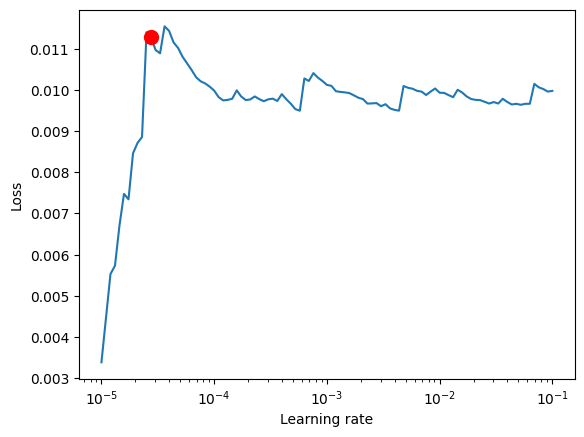

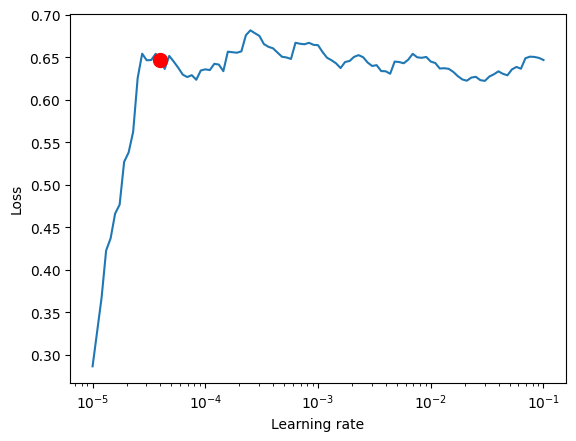

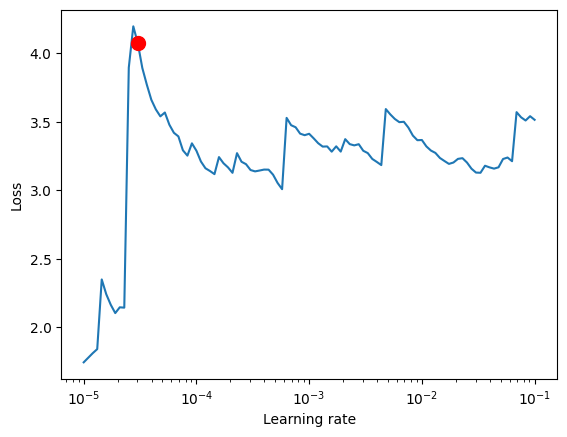

In [ ]:
models_config = {
    'gdp': {
        'target_col': 'l_GDP_dif',
        'result_model': 'tft_one_gdp',
        'result_training': 'tft_one_training_gdp'
    },
    'hhd': {
        'target_col': 'hd_dif',
        'result_model': 'tft_one_hhd',
        'result_training': 'tft_one_training_hhd'
    },
    'pd': {
        'target_col': 'pd_dif',
        'result_model': 'tft_one_pd',
        'result_training': 'tft_one_training_pd'
    }
}

trained_models = {}

for key, config in models_config.items():
    model, training = tft.train_temporal_fusion_transformer(
        train_data=train,
        max_prediction_length=max_prediction_length_onestep,
        max_encoder_length=max_encoder_length_onestep,
        max_epochs=50,
        target_col=config['target_col'],
        group_ids=['Country_index'],
        known_reals=inputs,
        batch_size=batch_size,
        patience=30,
        learning_rate=None,
        loss="RMSE"
    )
    
    #stores results
    trained_models[key] = {
        'model': model,
        'training': training,
        'target_column': config['target_col'],
        'lag_column': f"{config['target_col']}_lag1"
    }

# tft_one_gdp = trained_models['gdp']['model']
# tft_one_training_gdp = trained_models['gdp']['training']

In [ ]:
predictions = {}
actuals = {}

working_df = df.copy()

for key, config in trained_models.items():
    predictions[key], actuals[key] = tft.predict_over_time_steps(
        df=df,
        tft_onestep=config['model'],
        training=config['training'],
        start_time_idx=start_time_idx,
        max_encoder_length_onestep=max_encoder_length_onestep,
        num_steps=1,
        batch_size=batch_size,
        device=DEVICE,
    )


max_time_idx = start_time_idx

new_rows = []

country_indices = test['Country_index'].unique()
print(max_time_idx)
for country_idx in country_indices:
    latest_country_data = test[test['Country_index'] == country_idx].sort_values('time_idx').iloc[-1]
  
    new_row = {
        'time_idx': max_time_idx + 1,
        'Country_index': country_idx
    }
    

    for key, config in trained_models.items():
        country_pred = predictions[key][tft.get_country_index(test, country_idx)]
        new_row[config['target_column']] = country_pred
        new_row[config['lag_column']] = latest_country_data[config['target_column']]
    
    new_rows.append(new_row)

new_data = pd.DataFrame(new_rows)

current_time_idx = start_time_idx
working_df = working_df[working_df['time_idx'] <= current_time_idx]
working_df= pd.concat([working_df, new_data], ignore_index=True)
updated_df = working_df.sort_values(by=['Country_index', 'time_idx'])
current_time_idx += 1


updated_df


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/P

37


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


,time_idx,Country_index,l_GDP_dif,hd_dif,pd_dif,l_GDP_dif_lag1,hd_dif_lag1,pd_dif_lag1
0,1,Argentina,0.007642,-0.1,-0.200001,0.003586,0.100000,-1.299999
1,2,Argentina,-0.046987,0.2,0.1,0.007642,-0.100000,-0.200001
2,3,Argentina,-0.036652,-0.1,0.5,-0.046987,0.200000,0.100000
3,4,Argentina,-0.024878,0.0,0.200001,-0.036652,-0.100000,0.500000
4,5,Argentina,0.039711,-0.1,-0.400002,-0.024878,0.000000,0.200001
...,...,...,...,...,...,...,...,...
1439,34,United States,0.005527,-0.099998,-0.400002,0.007069,0.400002,0.500000
1440,35,United States,0.004857,-0.5,0.800003,0.005527,-0.099998,-0.400002
1441,36,United States,0.005584,0.099998,0.599998,0.004857,-0.500000,0.800003
1442,37,United States,0.007854,0.0,0.099998,0.005584,0.099998,0.599998


In [ ]:
def deepvar_predict(
    df,
    trained_models,
    start_time_idx,
    max_encoder_length_onestep,
    batch_size,
    num_steps=1,
    DEVICE="cpu"
):
    """
    Make predictions using DeepVAR model for multiple time steps.
    
    Args:
        df: DataFrame with time series data
        trained_models: Dictionary of trained models with configs
        start_time_idx: Starting time index for predictions
        max_encoder_length_onestep: Max encoder length for one-step prediction
        batch_size: Batch size for predictions
        num_steps: Number of time steps to predict 
        DEVICE: Device to run predictions on (default: "cpu")
        
    Returns:
        Updated DataFrame with predictions for all time steps
    """
    working_df = df.copy()
    current_time_idx = start_time_idx
    
    # predict for each time step
    for step in range(num_steps-1):
        predictions = {}
        actuals = {}
        
        # generate predictions
        for key, config in trained_models.items():
            predictions[key], actuals[key] = tft.predict_over_time_steps(
                df=working_df,
                tft_onestep=config['model'],
                training=config['training'],
                start_time_idx=current_time_idx,
                max_encoder_length_onestep=max_encoder_length_onestep,
                num_steps=1,
                batch_size=batch_size,
                device=DEVICE,
            )
        
            new_rows = []
        
        test = working_df[working_df['time_idx'] > (current_time_idx - max_encoder_length_onestep)]
        country_indices = test['Country_index'].unique()
        
        for country_idx in country_indices:
            latest_country_data = test[test['Country_index'] == country_idx].sort_values('time_idx').iloc[-1]
            
            new_row = {
                'time_idx': current_time_idx + 1,
                'Country_index': country_idx
            }
            
            # add predictions and lags
            for key, config in trained_models.items():
                country_pred = predictions[key][tft.get_country_index(test, country_idx)][0][0].item()
                new_row[config['target_column']] = country_pred
                new_row[config['lag_column']] = latest_country_data[config['target_column']]
            
            new_rows.append(new_row)
        
        new_data = pd.DataFrame(new_rows)
        filtered_df = working_df[working_df['time_idx'] <= current_time_idx]
        working_df = pd.concat([filtered_df, new_data], ignore_index=True)
        working_df = working_df.sort_values(by=['Country_index', 'time_idx'])
        
        current_time_idx += 1
    
    return working_df

forecast_df = deepvar_predict(
    df=df,
    trained_models=trained_models,
    start_time_idx=start_time_idx,
    max_encoder_length_onestep=max_encoder_length_onestep,
    batch_size=batch_size,
    num_steps=10,  
    DEVICE=DEVICE
)

forecast_df


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/P

,time_idx,Country_index,l_GDP_dif,hd_dif,pd_dif,l_GDP_dif_lag1,hd_dif_lag1,pd_dif_lag1
0,1,Argentina,0.007642,-0.100000,-0.200001,0.003586,0.100000,-1.299999
1,2,Argentina,-0.046987,0.200000,0.100000,0.007642,-0.100000,-0.200001
2,3,Argentina,-0.036652,-0.100000,0.500000,-0.046987,0.200000,0.100000
3,4,Argentina,-0.024878,0.000000,0.200001,-0.036652,-0.100000,0.500000
4,5,Argentina,0.039711,-0.100000,-0.400002,-0.024878,0.000000,0.200001
...,...,...,...,...,...,...,...,...
1751,42,United States,0.003897,-0.732702,-0.013112,0.004033,-0.719671,0.001737
1752,43,United States,0.003883,-0.736388,-0.015490,0.003897,-0.732702,-0.013112
1753,44,United States,0.003854,-0.739900,-0.019158,0.003883,-0.736388,-0.015490
1754,45,United States,0.003906,-0.738715,-0.017245,0.003854,-0.739900,-0.019158


In [ ]:

from kneed import KneeLocator

def deepvar_predict_steadystate(
    df,
    trained_models,
    start_time_idx,
    max_encoder_length_onestep,
    batch_size,
    max_steps=1000,  
    convergence_threshold=1e-4,  
    horizon=24,  
    check_every=10,  
):
    working_df = df.copy()
    current_time_idx = start_time_idx
    
    state_history = []
    convergence_info = {
        'converged': False,
        'steps_to_convergence': None,
        'quasi_steady_state': None,
        'final_distance': None,
        'distance_history': []
    }

    for step in range(max_steps):
        predictions = {}
        actuals = {}
        
        for key, config in trained_models.items():
            predictions[key], actuals[key] = tft.predict_over_time_steps(
                df=working_df,
                tft_onestep=config['model'],
                training=config['training'],
                start_time_idx=current_time_idx,
                max_encoder_length_onestep=max_encoder_length_onestep,
                num_steps=1,
                batch_size=batch_size,
                device=DEVICE,
            )
        
        new_rows = []
        
        test = working_df[working_df['time_idx'] > (current_time_idx - max_encoder_length_onestep)]
        country_indices = test['Country_index'].unique()
        
        for country_idx in country_indices:
            latest_country_data = test[test['Country_index'] == country_idx].sort_values('time_idx').iloc[-1]
            
            new_row = {
                'time_idx': current_time_idx + 1,
                'Country_index': country_idx
            }
            
            for key, config in trained_models.items():
                country_pred = predictions[key][tft.get_country_index(test, country_idx)][0][0].item()
                new_row[config['target_column']] = country_pred
                new_row[config['lag_column']] = latest_country_data[config['target_column']]
            
            new_rows.append(new_row)
        
        new_data = pd.DataFrame(new_rows)
        filtered_df = working_df[working_df['time_idx'] <= current_time_idx]
        working_df = pd.concat([filtered_df, new_data], ignore_index=True)
        working_df = working_df.sort_values(by=['Country_index', 'time_idx'])
        
        current_time_idx += 1
        
        current_state = extract_current_state(working_df, current_time_idx, trained_models)
        state_history.append(current_state)
        
        if step % check_every == 0 and step >= horizon:
            is_converged, distance = check_quasi_steady_state(
                state_history, 
                horizon=horizon, 
                convergence_threshold=convergence_threshold
            )
            
            convergence_info['distance_history'].append((step, distance))
            
            if is_converged:
                convergence_info['converged'] = True
                convergence_info['steps_to_convergence'] = step
                convergence_info['quasi_steady_state'] = current_state
                convergence_info['final_distance'] = distance
                print(f"Converged to quasi-steady state after {step} steps with distance {distance:.6f}")
                break
    
    if not convergence_info['converged']:
        print(f"Did not converge within {max_steps} steps")
        if len(convergence_info['distance_history']) > 0:
            min_dist_step, min_dist = min(convergence_info['distance_history'], key=lambda x: x[1])
            print(f"Minimum distance {min_dist:.6f} achieved at step {min_dist_step}")
    
    return working_df, convergence_info

from sklearn.metrics.pairwise import euclidean_distances

def extract_current_state(df, time_idx, trained_models):
    """
    Extract the current state of the system at a given time index.
    
    Args:
        df: DataFrame with time series data
        time_idx: Time index to extract state from
        trained_models: Dictionary of trained models with configs
        
    Returns:
        Dictionary mapping country indices to their state vectors
    """
    current_df = df[df['time_idx'] == time_idx]
    state = {}
    
    for _, row in current_df.iterrows():
        country_idx = row['Country_index']
        state_vector = []
        
        for key, config in trained_models.items():
            state_vector.append(row[config['target_column']])
        
        state[country_idx] = np.array(state_vector)
    
    return state

def compute_horizon_average(state_history, horizon):
    """
    Compute the horizon average s̄(y*) as defined in the paper.

    """
    if len(state_history) < horizon:
        raise ValueError(f"State history length {len(state_history)} is less than horizon {horizon}")
    
    recent_states = state_history[-horizon:]
    
    avg_state = {}
    for country_idx, state_vector in recent_states[0].items():
        avg_state[country_idx] = np.zeros_like(state_vector)
    
    for state in recent_states:
        for country_idx, state_vector in state.items():
            avg_state[country_idx] += state_vector
    
    for country_idx in avg_state.keys():
        avg_state[country_idx] /= horizon
    
    return avg_state

def calculate_euclidean_norm(state1, state2):
    """
    Calculate the normalized Euclidean norm between two states.
    """
    squared_sum = 0.0
    countries = set(state1.keys())
    
    scales = {}
    for country_idx in countries:
        var_count = len(state1[country_idx])
        for i in range(var_count):
            var_name = f"var_{i}" 
            if var_name not in scales:
                scales[var_name] = []
            scales[var_name].append(abs(state1[country_idx][i]))
            scales[var_name].append(abs(state2[country_idx][i]))
    
    for var_name in scales:
        scales[var_name] = max(1e-8, np.mean(scales[var_name]))
    
    for country_idx in countries:
        var_count = len(state1[country_idx])
        for i in range(var_count):
            var_name = f"var_{i}"
            diff = (state1[country_idx][i] - state2[country_idx][i]) / scales[var_name]
            squared_sum += diff ** 2
    
    return np.sqrt(squared_sum)

def check_quasi_steady_state(state_history, horizon, convergence_threshold):
    """
    Check if the system has converged to a quasi-steady state.
    
    Args:
        state_history: List of state dictionaries
        horizon: Horizon H for averaging
        convergence_threshold: Threshold η for quasi-steady state
        
    Returns:
        Tuple of (is_converged, distance)
    """
    if len(state_history) < horizon + 1:
        return False, float('inf')
    

    current_state = state_history[-1]
    
    horizon_avg = compute_horizon_average(state_history, horizon)
    
    distance = calculate_euclidean_norm(current_state, horizon_avg)
    
    is_converged = distance <= convergence_threshold
    
    return is_converged, distance

def analyze_quasi_steady_states(
    df,
    trained_models,
    start_time_idx,
    max_encoder_length_onestep,
    batch_size,
    convergence_threshold=1e-4,
    horizon=24,
    num_simulations=5,
    max_steps=1000,
    DEVICE="cpu"
):
    """
    Analyze quasi-steady states from multiple starting points.
    """
    results = {
        'simulations': [],
        'summary': {
            'num_converged': 0,
            'avg_steps_to_convergence': 0,
            'steady_states': []
        }
    }
    
    for sim_idx in range(num_simulations):
        print(f"Starting simulation {sim_idx+1}/{num_simulations}")
        
        perturbed_df = perturb_dataframe(df.copy(), perturbation_scale=0.05)
        
        
        forecast_df, convergence_info = deepvar_predict_steadystate(
            df=perturbed_df,
            trained_models=trained_models,
            start_time_idx=start_time_idx,
            max_encoder_length_onestep=max_encoder_length_onestep,
            batch_size=batch_size,
            max_steps=max_steps,
            convergence_threshold=convergence_threshold,
            horizon=horizon,
        )
        
        results['simulations'].append({
            'simulation_idx': sim_idx,
            'convergence_info': convergence_info,
            'final_df': forecast_df
        })
        
        if convergence_info['converged']:
            results['summary']['num_converged'] += 1
            results['summary']['avg_steps_to_convergence'] += convergence_info['steps_to_convergence']
            results['summary']['steady_states'].append(convergence_info['quasi_steady_state'])
    
    # avg steps to convergence
    if results['summary']['num_converged'] > 0:
        results['summary']['avg_steps_to_convergence'] /= results['summary']['num_converged']
    
    if results['summary']['num_converged'] > 0:
        results['summary']['steady_state_clusters'] = cluster_steady_states(
            results['summary']['steady_states']
        )
    
    return results

def perturb_dataframe(df, perturbation_scale=0.05):
    """
    Add small random perturbations to the target variables.
    """
    perturbed_df = df.copy()
    
    target_columns = [col for col in df.columns 
                     if not col.startswith('lag_') 
                     and col not in ['time_idx', 'Country_index']]
    
    for col in target_columns:
        std = df[col].std()
        
        perturbation = np.random.normal(0, std * perturbation_scale, size=len(df))
        
        perturbed_df[col] = df[col] + perturbation
    
    return perturbed_df

def cluster_steady_states(steady_states, max_clusters=3):
    """
    Cluster the steady states to find common patterns.
    """
    flat_states = []
    country_indices = list(steady_states[0].keys())
    
    for state in steady_states:
        flat_state = []
        for country_idx in country_indices:
            flat_state.extend(state[country_idx])
        flat_states.append(flat_state)
    
    flat_states = np.array(flat_states)
    
    #edge case of few steady states
    if len(flat_states) <= max_clusters:
        return {'clusters': list(range(len(flat_states))), 'centroids': flat_states}
    
    from sklearn.cluster import KMeans
    
    inertias = []
    k_range = range(1, min(max_clusters + 1, len(flat_states)))
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(flat_states)
        inertias.append(kmeans.inertia_)
    
    
    kneedle = KneeLocator(list(k_range), inertias, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow if kneedle.elbow else max(k_range)
    
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(flat_states)
    
    centroids = []
    for centroid in kmeans.cluster_centers_:
        centroid_dict = {}
        offset = 0
        for country_idx in country_indices:
            var_count = len(steady_states[0][country_idx])
            centroid_dict[country_idx] = centroid[offset:offset+var_count]
            offset += var_count
        centroids.append(centroid_dict)
    
    return {
        'optimal_k': optimal_k,
        'clusters': clusters.tolist(),
        'centroids': centroids,
        'inertias': inertias
    }

def plot_convergence_distances(results):
    plt.figure(figsize=(12, 8))
    
    for i, sim in enumerate(results['simulations']):
        distances = sim['convergence_info']['distance_history']
        if distances:
            steps, dist_values = zip(*distances)
            plt.plot(steps, dist_values, marker='o', label=f"Simulation {i+1}")
    
    plt.axhline(y=convergence_threshold, color='r', linestyle='--', 
                label=f"Convergence threshold (η={convergence_threshold})")
    
    plt.title("Convergence to Quasi-Steady State")
    plt.xlabel("Simulation Steps")
    plt.ylabel("Euclidean Distance ||s̄(y*) - y*||")
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

convergence_threshold = 1e-2 
horizon = 40 
max_steps = 100 
num_simulations = 40

results = analyze_quasi_steady_states(
    df=df,
    trained_models=trained_models,
    start_time_idx=start_time_idx,
    max_encoder_length_onestep=max_encoder_length_onestep,
    batch_size=batch_size,
    convergence_threshold=convergence_threshold,
    horizon=horizon,
    num_simulations=num_simulations,
    max_steps=max_steps,
    DEVICE=DEVICE
)

print(f"Summary of Quasi-Steady State Analysis:")
print(f"- {results['summary']['num_converged']}/{num_simulations} simulations converged")
print(f"- Average steps to convergence: {results['summary']['avg_steps_to_convergence']:.1f}")

if results['summary']['num_converged'] > 0:
    cluster_results = results['summary']['steady_state_clusters']
    print(f"- Found {len(set(cluster_results['clusters']))} distinct steady state clusters")

plot_convergence_distances(results)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting simulation 1/40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:42

In [ ]:
steadystate_df = pd.DataFrame(results['simulations'][0]['convergence_info']['quasi_steady_state']).T
steadystate_df.columns = ['l_GDP_dif', 'hd_dif', 'pd_dif'] 

steadystate_df



,l_GDP_dif,hd_dif,pd_dif
Argentina,0.009002,0.018113,-0.065798
Australia,0.006311,0.357673,-0.143466
Austria,0.002810,-0.068576,0.178129
Belgium,0.002400,0.206744,2.322059
Brazil,0.006417,0.195392,0.342768
Canada,0.003019,0.598190,0.591291
Chile,0.008210,0.250032,1.310913
"China, P.R.: Hong Kong",0.009276,0.411195,4.497530
Colombia,0.009487,0.237905,0.338122
Czech Rep.,0.003408,0.104956,0.191520


In [ ]:
df[df["time_idx"] ==36]

time_idx           Country_index  \
TIME_PERIOD Country                                                    
2017-06-30  Argentina                     36               Argentina   
            Australia                     36               Australia   
            Austria                       36                 Austria   
            Belgium                       36                 Belgium   
            Brazil                        36                  Brazil   
            Canada                        36                  Canada   
            Chile                         36                   Chile   
            China, P.R.: Hong Kong        36  China, P.R.: Hong Kong   
            Colombia                      36                Colombia   
            Czech Rep.                    36              Czech Rep.   
            Denmark                       36                 Denmark   
            Finland                       36                 Finland   
            France                        36                  France   
            Germany                       36                 Germany   
            Greece                        36                  Greece   
            Hungary                       36                 Hungary   
            India                         36                   India   
            Indonesia                     36               Indonesia   
            Ireland                       36                 Ireland   
            Israel                        36                  Israel   
            Italy                         36                   Italy   
            Japan                         36                   Japan   
            Korea, Rep. of                36          Korea, Rep. of   
            Luxembourg                    36              Luxembourg   
            Mexico                        36                  Mexico   
            Netherlands, The              36        Netherlands, The   
            New Zealand                   36             New Zealand   
            Norway                        36                  Norway   
            Poland, Rep. of               36         Poland, Rep. of   
            Portugal                      36                Portugal   
            Singapore                     36               Singapore   
            South Africa                  36            South Africa   
            Spain                         36                   Spain   
            Sweden                        36                  Sweden   
            Switzerland                   36             Switzerland   
            Thailand                      36                Thailand   
            Türkiye, Rep of               36         Türkiye, Rep of   
            United Kingdom                36          United Kingdom   
            United States                 36           United States   

                                    l_GDP_dif    hd_dif     pd_dif  \
TIME_PERIOD Country                                                  
2017-06-30  Argentina                0.009445  0.100000   0.800000   
            Australia                0.006201  0.200005  -0.400002   
            Austria                  0.006469 -0.199997  -0.800003   
            Belgium                  0.002412  0.399998  -3.399994   
            Brazil                   0.007933  0.100000  -0.200001   
            Canada                   0.010470  0.199997  -0.500000   
            Chile                    0.012871  0.299999  -0.500000   
            China, P.R.: Hong Kong   0.009078  1.099999  13.100006   
            Colombia                 0.004780  0.444000  -0.356003   
            Czech Rep.               0.024059  0.100000  -0.400002   
            Denmark                  0.011992 -1.099999  -1.500000   
            Finland                  0.013066  0.100006   1.800003   
            France                   0.008933  0.400002  -0.099991   
            Germany              

In [ ]:
new_df = pd.read_csv("/Users/bram/Desktop/Honors Draft for Reviewers/Honors-DeepVAR-Household-Debt-Analysis/Results/Data/WithPolicyRate.csv")

new_df = new_df[new_df["TIME_PERIOD"] == "2017-06-30"]
new_df = new_df[['household_debt', 'Country']]